# Random Forests 5

---

__This Notebook__

- Evaluates the results of the previous notebook's grid searches
- Conducts a final grid search

__Results__ 

- Less trees (200 instead of 500) and less depth (10, not 20, 30) seem to perform better
- The final search shows improvement but mostly due to a 500-component (vs a 300 one) SVD

__Next Notebook__

- Evaluate results of this notebook's search
- Pick final model by tuning the decision threshold to reasonably maximize sensitivity

---

## Setup & Load Results

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp

import custom.new_gridsearch as ng

from datetime import datetime

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-19


In [2]:
# load grid searches
mod_path = os.path.join("data", "3_modeling")
filename_old = '01182021_rf_gridsearch_old.joblib'
filename_deeper = '01182021_rf_gridsearch_deeper.joblib'
                
gridsearch_old = joblib.load(os.path.join(mod_path, filename_old))
gridsearch_deeper = joblib.load(os.path.join(mod_path, filename_deeper))

In [3]:
# extract and transform dfs
def transform_dfs(gridsearches):

    def extract_df(dic):
        gd_X = dic['representation']
        gd_res = dic['gridsearch_res'].cv_results_
        df = pd.concat([
                        pd.DataFrame({'representation':[gd_X] * len(gd_res["params"])}),
                        pd.DataFrame(gd_res["params"]),
                        pd.DataFrame(gd_res["mean_test_acc"], columns=["mean_val_acc"]),
                        pd.DataFrame(gd_res["mean_test_tpr"], columns=["mean_val_tpr"]),
                        pd.DataFrame(gd_res["mean_test_tnr"], columns=["mean_val_tnr"]),
                        pd.DataFrame(gd_res["mean_fit_time"], columns=["mean_fit_time"])
                       ]
                       , axis=1)
        return df
    
    # create list of dfs
    df_list = []
    for ix, dic in enumerate(gridsearches):
        df_list.append(extract_df(dic))

    # flatten and reindex
    dfm = pd.concat(df_list)
    dfm.index = range(len(dfm))

    # sort by top mean validation sensitivity
    return dfm.sort_values(by=['mean_val_tpr'], ascending=False)

In [4]:
df_old = transform_dfs(gridsearch_old)
df_old

,representation,max_features,max_leaf_nodes,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time
0,X_bot_cossim_bot,50,99,500,0.988375,0.935628,0.996454,60.023415
1,X_bot_cossim_bot,100,99,500,0.987007,0.935560,0.994879,98.600802
2,X_bot_cossim_bot,250,99,500,0.986324,0.935493,0.994090,190.024828
4,X_tfidf_cossim_tfidf,100,99,500,0.987007,0.922672,0.996846,100.325287
5,X_tfidf_cossim_tfidf,250,99,500,0.986325,0.922672,0.996058,215.498491
3,X_tfidf_cossim_tfidf,50,99,500,0.986667,0.917544,0.997239,57.952526


In [5]:
df_deeper = transform_dfs(gridsearch_deeper)
df_deeper.iloc[:16,:]

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time
48,X_tfidf_cossim_tfidf,10,150,5,200,0.989744,0.943185,0.996849,45.527731
66,X_tfidf_cossim_tfidf,20,150,5,200,0.989401,0.943185,0.996454,45.295489
59,X_tfidf_cossim_tfidf,20,50,15,500,0.989401,0.940553,0.996849,48.656113
49,X_tfidf_cossim_tfidf,10,150,5,500,0.989060,0.940553,0.996455,116.696879
50,X_tfidf_cossim_tfidf,10,150,10,200,0.989059,0.940553,0.996454,46.742169
51,X_tfidf_cossim_tfidf,10,150,10,500,0.989059,0.940553,0.996454,115.813222
52,X_tfidf_cossim_tfidf,10,150,15,200,0.989401,0.940553,0.996849,44.398987
53,X_tfidf_cossim_tfidf,10,150,15,500,0.989059,0.940553,0.996454,112.648805
57,X_tfidf_cossim_tfidf,20,50,10,500,0.989401,0.940553,0.996849,47.979415
58,X_tfidf_cossim_tfidf,20,50,15,200,0.989059,0.940553,0.996454,18.026865


Curiously, sensitivity is lower for the tfidf than for the bot in the first and limited run, but the deeper grid search shows tfidf as the winner - as we expected from the original tutorial.

Also curious: seems as if a *lower number of trees and lower depth perform better*. The other params conform to expectation.

I'll do a final grid search using the following grid, and also vary the number of **SVD components** to include `500` - but limit to **tfidf only**.

```
final_params = {
    'n_estimators' : [100, 150, 200],    # focusing on relatively low number
    'max_features': [150, 200, 250],     # upping the max (total=300)
    'max_depth': [5, 10],                # keeping trees pruned
    'min_samples_split': [5]             # constant
}
```

### Visualize results above

In [6]:
import matplotlib.pyplot as plt

def plot_topscores(X, xlab=True):
    if xlab:
        X['xticks'] = X.agg(lambda x: \
            f"{x['representation']}-{x['max_features']}-{x['n_estimators']}"
            , axis=1)
    plt.figure(figsize=(14, 8))
    plt.plot(np.array(X['mean_val_acc']), label="mean validation accuracy")
    plt.plot(np.array(X['mean_val_tpr']), label="mean validation sensitivity")
    plt.plot(np.array(X['mean_val_tnr']), label="mean validation specificiy")
    plt.title('Evaluating Top Representations and Models', fontsize=14)
    plt.legend(loc="lower left", fontsize=12)
    plt.axis([0, len(X)-1, 0.9, 1.01])
    if xlab:
        plt.xticks(np.arange(len(X)), tuple(X['xticks']))
        plt.xticks(rotation=45, ha="right")
    plt.show()

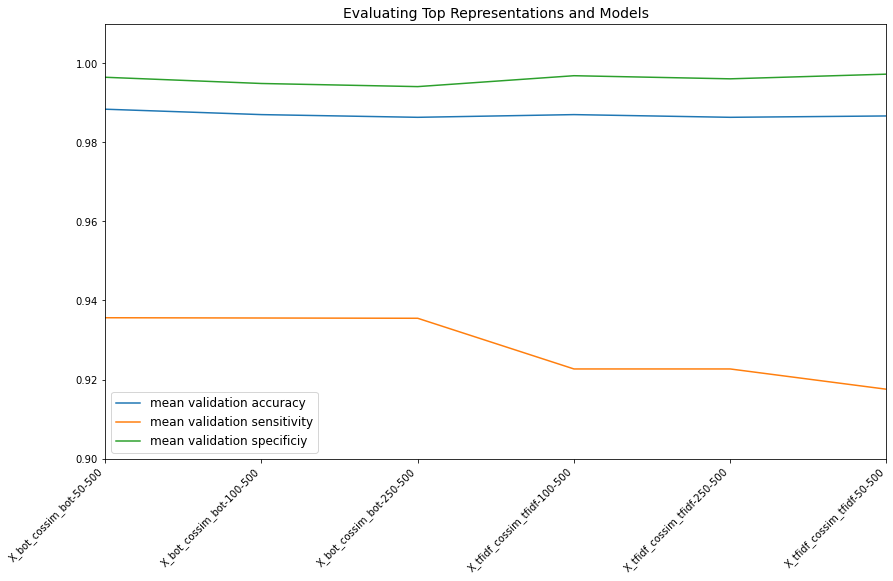

In [7]:
plot_topscores(df_old)

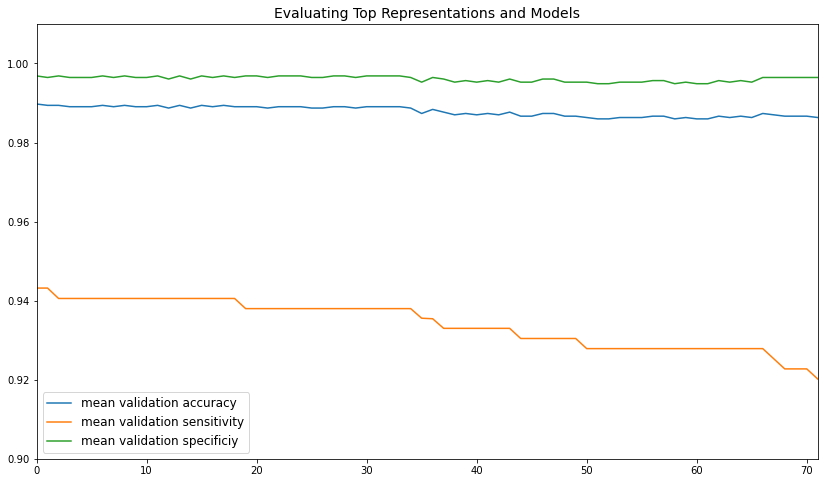

In [8]:
plot_topscores(df_deeper, xlab=False)

In [9]:
df_deeper.tail(12)

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time
17,X_bot_cossim_bot,10,150,15,500,0.985981,0.927868,0.994877,130.876145
35,X_bot_cossim_bot,20,150,15,500,0.985981,0.927868,0.994877,127.895026
20,X_bot_cossim_bot,20,50,10,200,0.986667,0.927868,0.995665,23.821936
32,X_bot_cossim_bot,20,150,10,200,0.986324,0.927868,0.995271,55.868437
31,X_bot_cossim_bot,20,150,5,500,0.986666,0.927868,0.995665,140.201392
30,X_bot_cossim_bot,20,150,5,200,0.986324,0.927868,0.995271,55.671916
4,X_bot_cossim_bot,10,50,15,200,0.987349,0.927868,0.996452,21.474042
5,X_bot_cossim_bot,10,50,15,500,0.987007,0.925304,0.996452,52.496439
3,X_bot_cossim_bot,10,50,10,500,0.986666,0.922740,0.996452,50.922734
1,X_bot_cossim_bot,10,50,5,500,0.986666,0.922740,0.996452,51.056234


### Final Grid Search for Random Forests

In [10]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

y = y_train.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

In [11]:
import custom.clean_preprocess as cp

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))])

X_tfidf = pipe.fit_transform(X_train)

In [12]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

def perform_SVD(X, n_components=300):
    
    X_array = X.asfptype()
    U, Sigma, VT = svds(X_array.T,
                        k=n_components)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    
    # return V 
    V = VT.T
    return V # do not scale 

X_tfidf_svd300 = perform_SVD(X_tfidf)
X_tfidf_svd500 = perform_SVD(X_tfidf, n_components=500) # new representation

In [13]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

X_tfidf_svd300_allcos = cosine_similarity(X_tfidf_svd300)
X_tfidf_svd500_allcos = cosine_similarity(X_tfidf_svd500)

train_df = pd.DataFrame({'sms':X_train, 'target':y_train})

# get spam indexes
spam_ix = train_df.loc[train_df['target']=='spam'].index

# calculate average spam similarity on SVD
mean_spam_sims300, mean_spam_sims500 = [], []

for ix in range(X_tfidf_svd300_allcos.shape[0]):
    mean_spam_sims300.append(np.mean(X_tfidf_svd300_allcos[ix, spam_ix]))
    mean_spam_sims500.append(np.mean(X_tfidf_svd500_allcos[ix, spam_ix]))

X_tfidf_svd300_spamcos = sp.hstack((csr_matrix(mean_spam_sims300).T, X_tfidf_svd300)) 
X_tfidf_svd500_spamcos = sp.hstack((csr_matrix(mean_spam_sims500).T, X_tfidf_svd500)) 

In [14]:
Xs = [X_tfidf_svd300_spamcos, X_tfidf_svd500_spamcos]
Xnames = ['X_tfidf_svd300_spamcos', 'X_tfidf_svd500_spamcos']

In [15]:
# sanity check
Xs

[<3900x301 sparse matrix of type '<class 'numpy.float64'>'
 	with 1173599 stored elements in COOrdinate format>,
 <3900x501 sparse matrix of type '<class 'numpy.float64'>'
 	with 1953399 stored elements in COOrdinate format>]

In [16]:
final_params = {
    'n_estimators' : [100, 150, 200],    # keep medium
    'max_features': [150, 200, 250],     # keep high
    'max_depth': [5, 8],                 # keep low
    'min_samples_split': [3, 5]          # keep low
}

In [17]:
# final run
grid_search_clf = ng.gridsearch_wrapper(Xs, Xnames, y, final_params, n_jobs=-1)


Training 1: X_tfidf_svd300_spamcos...
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 40.9min finished


Elapsed: 2457 s
Best params: {'max_depth': 5, 'max_features': 150, 'min_samples_split': 3, 'n_estimators': 100}
Confusion matrix on validation set:
     pred_neg  pred_pos
neg       843         3
pos         6       123
Evaluation metrics:
accuracy: 0.9908
sensitivity: 0.9535
specificity: 0.9965

Training 2: X_tfidf_svd500_spamcos...
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 42.2min finished


Elapsed: 2538 s
Best params: {'max_depth': 5, 'max_features': 250, 'min_samples_split': 3, 'n_estimators': 100}
Confusion matrix on validation set:
     pred_neg  pred_pos
neg       844         2
pos         7       122
Evaluation metrics:
accuracy: 0.9908
sensitivity: 0.9457
specificity: 0.9976

Elapsed: 83 m 15 s


I'm noticing that these single evaluations with the confusion matrix are not to be believed too much. The 10-fold CV below tells another story. 

In [18]:
# check save path
save_path = os.path.join(mod_path, "".join(["01192021", "_rf_gridsearches.joblib"]))
save_path

'data\\3_modeling\\01192021_rf_gridsearches.joblib'

In [19]:
# persist gridsearches
joblib.dump(grid_search_clf, save_path)

['data\\3_modeling\\01192021_rf_gridsearches.joblib']

In [20]:
final_df = transform_dfs(grid_search_clf)
final_df

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time
71,X_tfidf_svd500_spamcos,8,250,5,200,0.992483,0.963900,0.996847,81.768335
58,X_tfidf_svd500_spamcos,8,150,5,150,0.992483,0.963900,0.996847,38.167616
48,X_tfidf_svd500_spamcos,5,250,3,100,0.992483,0.963900,0.996847,30.677184
49,X_tfidf_svd500_spamcos,5,250,3,150,0.992483,0.963900,0.996847,45.423729
50,X_tfidf_svd500_spamcos,5,250,3,200,0.992483,0.963900,0.996847,63.327345
...,...,...,...,...,...,...,...,...,...
13,X_tfidf_svd300_spamcos,5,250,3,150,0.986665,0.930364,0.995272,45.372178
14,X_tfidf_svd300_spamcos,5,250,3,200,0.986665,0.930364,0.995272,63.178943
15,X_tfidf_svd300_spamcos,5,250,5,100,0.986665,0.930364,0.995272,30.540003
16,X_tfidf_svd300_spamcos,5,250,5,150,0.986665,0.930364,0.995272,45.020059


Curiously, best mean validation RP rates are not necessarily maxing out the number of trees, their depth, nor the number of estimators. Differences are very slight however.

## Visualize results

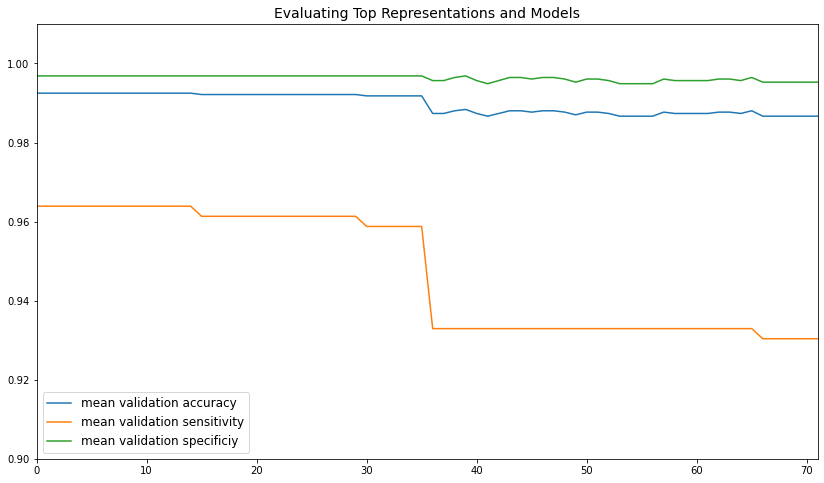

In [22]:
plot_topscores(final_df, xlab=False)

In [23]:
final_df.index = range(len(final_df))

In [25]:
final_df.iloc[30:40,:]

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time,xticks
30,X_tfidf_svd500_spamcos,5,150,5,150,0.991798,0.958772,0.996847,30.036404,X_tfidf_svd500_spamcos-150-150
31,X_tfidf_svd500_spamcos,5,150,5,200,0.991798,0.958772,0.996847,38.884571,X_tfidf_svd500_spamcos-150-200
32,X_tfidf_svd500_spamcos,8,150,3,200,0.991798,0.958772,0.996847,51.777059,X_tfidf_svd500_spamcos-150-200
33,X_tfidf_svd500_spamcos,8,150,5,200,0.991798,0.958772,0.996847,53.434350,X_tfidf_svd500_spamcos-150-200
34,X_tfidf_svd500_spamcos,5,150,3,150,0.991798,0.958772,0.996847,33.188753,X_tfidf_svd500_spamcos-150-150
35,X_tfidf_svd500_spamcos,5,150,3,200,0.991798,0.958772,0.996847,40.354604,X_tfidf_svd500_spamcos-150-200
36,X_tfidf_svd300_spamcos,8,150,3,100,0.987349,0.932928,0.995666,25.010788,X_tfidf_svd300_spamcos-150-100
37,X_tfidf_svd300_spamcos,5,200,5,200,0.987349,0.932928,0.995666,50.432216,X_tfidf_svd300_spamcos-200-200
38,X_tfidf_svd300_spamcos,5,200,5,150,0.988031,0.932928,0.996454,35.516674,X_tfidf_svd300_spamcos-200-150
39,X_tfidf_svd300_spamcos,5,200,5,100,0.988373,0.932928,0.996847,25.756463,X_tfidf_svd300_spamcos-200-100


We can see how the drop happens when we move from the 500-component to the 300-component SVD.

---